In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import time

from matplotlib import pyplot as plt
%matplotlib widget

In [3]:
from vectorized_pauli_decomposer.core.pauli_matrices import PAULI_I, PAULI_X, PAULI_Y, PAULI_Z, CORE_PAULI_STACK
from vectorized_pauli_decomposer.core.conversions import pauli_idx2pauli_list, pauli_list2pauli_idx
from vectorized_pauli_decomposer.core.batched import batched_kron, batched_rolling_kron

from vectorized_pauli_decomposer.decomposers import slow_dense_decompose, fast_dense_decompose

In [4]:
from vectorized_pauli_decomposer.custom_popcount.numpy_popcount import numpy_int64popcount, numpy_int64popcount_

In [5]:
a = np.random.randint(20000, size=(10000, 10000))

In [6]:
numpy_int64popcount(a)

array([[ 9,  6,  6, ...,  7,  7,  8],
       [ 8,  8,  5, ...,  9,  6,  5],
       [ 7,  5,  6, ...,  6,  8,  9],
       ...,
       [ 5,  6, 10, ...,  6,  8,  7],
       [10,  8,  6, ...,  9,  9,  8],
       [ 9,  8,  8, ...,  2,  6,  6]])

In [8]:
%timeit numpy_int64popcount_(a)

48.1 ms ± 1.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Initial simple functions to plot the base Pauli stack subjected to rolling cron

(-0.0, 1.0)

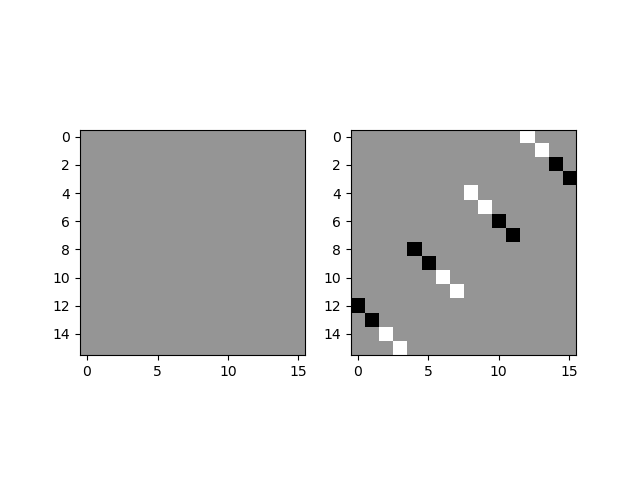

In [5]:
def rolling_kron(stack):
    assert len(stack.shape) == 3
    stack_height = stack.shape[0]
    result = stack[0]
    for layer_idx in range(1, stack_height):
        result = np.kron(stack[layer_idx], result)

    return result

def plot_complex(x):
    assert len(x.shape) == 2
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(x.real / np.abs(x).max(), cmap='Greys', vmin=-1, vmax=1)
    axes[1].imshow(x.imag / np.abs(x).max(), cmap='Greys', vmin=-1, vmax=1)

    return x.real.max(), x.imag.max()

def plot_batched_complex(x):
    assert len(x.shape) == 3
    
    fig, axes = plt.subplots(x.shape[0], 2)
    for batch_idx in range(x.shape[0]):
        axes[batch_idx, 0].imshow(x[batch_idx].real / np.abs(x[batch_idx]).max(), cmap='Greys', vmin=-1, vmax=1)
        axes[batch_idx, 1].imshow(x[batch_idx].imag / np.abs(x[batch_idx]).max(), cmap='Greys', vmin=-1, vmax=1)


    return None

plot_complex(rolling_kron(CORE_PAULI_STACK))

# Actual decomposition functions

In [6]:
def pauli_decompose(target: np.ndarray = None,
                    pauli_indices: np.ndarray = None,
                    qubit_num: int = None,
                    method: str = 'fast'):
    assert target is not None
    assert pauli_indices is not None
    assert qubit_num is not None
    assert method in ('dense', 'sparse', 'fast')

    if method == 'dense':
        return dense_pauli_decompose(target=target,
                                     pauli_indices=pauli_indices,
                                     qubit_num=qubit_num)
        
    elif method == 'sparse':
        raise NotImplementedError
        
    elif method == 'fast':
        fast_pauli_decompose(target=target,
                             pauli_indices=pauli_indices,
                             qubit_num=qubit_num)
    else:
        raise ValueError(f'Wrong method: {method}')

# Applying the functions

In [7]:
qubit_num = 9
pauli_indices = np.arange(2**(2 * qubit_num))
pauli_lists = pauli_idx2pauli_list(pauli_indices, qubit_num=qubit_num)
#pauli_stacks = BASE_PAULI_STACK[pauli_lists]
#pauli_matrices = batched_rolling_kron(pauli_stacks)

In [8]:
#target = np.random.normal(size=(2**qubit_num, 2**qubit_num)) + 1j * np.random.normal(size=(2**qubit_num, 2**qubit_num))
coeffs = slow_dense_decompose(target=target,
                               pauli_indices=pauli_indices, 
                               qubit_num=qubit_num)
# new_target = np.einsum('b,bij->ij', coeffs, pauli_matrices)
# print(np.allclose(new_target, target))

NameError: name 'target' is not defined

In [9]:
target = np.random.normal(size=(2**qubit_num, 2**qubit_num)) + 1j * np.random.normal(size=(2**qubit_num, 2**qubit_num))
fast_coeffs = fast_dense_decompose(target=target,
                                   pauli_indices=pauli_indices, 
                                    qubit_num=qubit_num)
# fast_target = np.einsum('b,bij->ij', fast_coeffs, pauli_matrices)
# print(np.allclose(fast_target, target))

In [9]:
np.allclose(coeffs, fast_coeffs)

True

In [10]:
%timeit slow_dense_decompose(target=target,\
                               pauli_indices=pauli_indices, \
                               qubit_num=qubit_num)

1.82 s ± 47.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%timeit fast_dense_decompose(target=target,\
                               pauli_indices=pauli_indices, \
                               qubit_num=qubit_num)

1.72 s ± 14.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
%timeit fast_dense_decompose(target=target,\
                               pauli_indices=pauli_indices, \
                               qubit_num=qubit_num)

3.35 s ± 390 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%timeit fast_dense_decompose(target=target,\
                               pauli_indices=pauli_indices, \
                               qubit_num=qubit_num)

2.58 s ± 27.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%timeit fast_dense_decompose(target=target,\
                               pauli_indices=pauli_indices, \
                               qubit_num=qubit_num)

2.3 s ± 23.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
